In [48]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf
from keras.models import load_model

import PIL
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from circle_fit import hyper_fit
from skimage.draw import line
from skimage.transform import resize
from skimage.measure import subdivide_polygon
from cv2 import equalizeHist, createCLAHE
import random
import math
import pickle
Image.MAX_IMAGE_PIXELS = 1000000000

class Rim(object):
    def __init__(self, coordinates, img, mosaic=None):
        self.mosaic = mosaic
        self.cropped = None
        self.target = None
        self.top = img.size[1]
        self.edge = img.size[0]
        self.coords = []
        for coord in coordinates:
            coords = [float(x) for x in coord.split('\t')]
            coords[1] = self.top - coords[1]
            coords = tuple(coords)
            self.coords.append(coords)
        X0 = np.array([x[0] for x in self.coords])
        X1 = np.array([x[1] for x in self.coords])
        if any(X0 < 0) or any(X0 > self.edge):
            raise ValueError('Trace point outside image boundaries')
        if any(X1 < 0) or any(X1 > self.top):
            raise ValueError('Trace point outside image boundaries')
        prev_crd = self.coords[-1]
        self.d = []
        for i, crd in enumerate(self.coords):
            d = np.sqrt(np.sum(np.square(np.array(crd) - np.array(prev_crd))))
            self.d.append(d)
            prev_crd = crd
        self.min_0 = min([x[0] for x in self.coords])
        self.min_1 = min([x[1] for x in self.coords])
        self.fit_circle()
        self.create_footprint(img)
        
    def fit_circle(self):
        """Fits a circle to the points on rim."""
        #X0 = [x[0] for x in self.coords]
        #X1 = [x[1] for x in self.coords]
        xc, yc, R, residu = hyper_fit(self.coords)
        self.c0 = xc
        self.c1 = yc
        self.r = R
        self.residual = residu
        self.res_ratio = self.residual/self.r
            
    def show(self, plot_circle=True):
        """Plots trace points in scatter plot."""
        scale_factor = 3
        scale = self.r * scale_factor * 2
        arr = np.array(self.cropped)
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(arr, cmap='Greys_r');
        ax.scatter([z[1] for z in self.coords], [z[0] for z in self.coords])
        if plot_circle:
            circle = plt.Circle((scale,scale),self.r, fill=False, linewidth=2, color='red')
            ax.add_artist(circle)
        plt.show();
        
    def create_footprint(self, img, in_dim=224, scale_factor=3):
        scale_factor = 3
        scale = self.r * scale_factor * 2
        self.scale = scale
        left = self.c0 - scale
        upper = self.c1 - scale
        right = self.c0 + scale
        lower = self.c1 + scale
        cropped = img.crop((left, upper, right, lower))
        dim = cropped.size[0]
        target = np.zeros((dim, dim))
        mean_d = np.array(self.d).mean()
        coords = []
        for coord in self.coords:
            crd = (coord[1] - self.c1 + scale, coord[0] - self.c0 + scale)
            coords.append(crd)
        self.coords = coords
        self.cropped = cropped
        return
        
    def create_target(self, img, in_dim=224, scale_factor=3):
        scale_factor = 3
        scale = self.r * scale_factor * 2
        left = self.c0 - scale
        upper = self.c1 - scale
        right = self.c0 + scale
        lower = self.c1 + scale
        cropped = img.crop((left, upper, right, lower))
        dim = cropped.size[0]
        target = np.zeros((dim, dim))
        mean_d = np.array(self.d).mean()
        for i, d in enumerate(self.d):
            if d < mean_d * 2.5:
                ln = line(
                    int(round(self.coords[i-1][1] - self.c1 + scale)), 
                    int(round(self.coords[i-1][0] - self.c0 + scale)), 
                    int(round(self.coords[i][1] - self.c1 + scale)), 
                    int(round(self.coords[i][0] - self.c0 + scale))
                )
                target[ln] = 255
        in_dim *= 2
        in_dim += 5
        in_dim = int(in_dim)
        target_image = Image.fromarray(np.uint8(target))
        cropped = cropped.resize((in_dim, in_dim), resample=PIL.Image.BILINEAR)
        target_image = target_image.resize((in_dim, in_dim), resample=PIL.Image.BILINEAR)
        self.cropped = cropped
        self.target = target_image
        return
    
    def get_pair(self, out_dim = 224, rotation=0, displace=(0,0), rescale=1):
        if self.cropped == None:
            raise Exception('No defined image/target pair')
        dim = int(out_dim*rescale)
        buff = (self.cropped.size[0] - dim)//2
        left = buff + displace[0]
        right = buff + dim + displace[0]
        top = buff + displace[1]
        bottom = buff + dim + displace[1]
        to_crop = self.cropped.rotate(rotation)
        target = self.target.rotate(rotation)
        img = to_crop.crop((left, top, right, bottom))
        target = target.crop((left, top, right, bottom))
        if img.size[0] != out_dim:
            img = img.resize((out_dim, out_dim), resample=PIL.Image.BILINEAR)
            target = target.resize((out_dim, out_dim), resample=PIL.Image.BILINEAR)
        return img, target
    
    def rotate_around_point(self, xy, radians, origin=(0, 0)):
        """Rotate a point around a given point.
        Credit: Lyle Scott
        https://gist.github.com/LyleScott/e36e08bfb23b1f87af68c9051f985302
        """
        x, y = xy
        offset_x, offset_y = origin
        adjusted_x = (x - offset_x)
        adjusted_y = (y - offset_y)
        cos_rad = math.cos(radians)
        sin_rad = math.sin(radians)
        qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
        qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y
        return qx, qy
    
    def draw_rim(self, crop_off=.25, res=224, rot=0, disp=(0,0), incl_coords=False):
        img = self.cropped
        dim = self.cropped.size[0]
        coords = self.coords
        out = []
        for pnt in coords:
            point = (pnt[1], pnt[0])
            as_radians = rot*math.pi/180
            point = self.rotate_around_point(point, as_radians, origin=(dim/2, dim/2))
            out.append((point[1], point[0]))
        coords = out
        img = img.rotate(rot)
        crop_off = int(crop_off*img.size[0])
        img_post_size = img.size[0]-(2*crop_off)
        res_factor = res/img_post_size
        disp0 = disp[0] / res_factor
        disp1 = disp[1] / res_factor
        img = img.crop((crop_off - disp1, crop_off-disp0, img.size[0]-crop_off-disp1, img.size[1]-crop_off-disp0))
        img = img.resize((res, res), resample=PIL.Image.BILINEAR)
        arr = np.array(img)
        coords = [(((x[0]-crop_off) * res_factor)+disp[0], ((x[1]-crop_off) * res_factor)+disp[1]) for x in coords]
        target = np.zeros((res, res))
        coords = np.array([list(x) for x in coords])
        coord_groups=[]
        mean_d = np.mean(self.d)
        std = np.std(self.d)
        crds = []
        thresh = 2.5
        for i, d in enumerate(self.d):
            if i == 0:
                if d < thresh*mean_d:
                    crds.append(coords[-1])
            if d < thresh*mean_d:
                crds.append(coords[i])
            elif len(crds) > 1:
                crds = np.array([list(x) for x in crds])
                coord_groups.append(crds)
                crds = []
            else:
                pass
        crds = np.array([list(x) for x in crds])
        coord_groups.append(crds)
        for crds in coord_groups:
            new_coords = crds.copy()
            for _ in range(5):
                new_coords = subdivide_polygon(new_coords, degree=2, preserve_ends=True)
            crds = new_coords
            rounded = set()
            for crd in crds:
                nxt = (int(round(crd[0])), int(round(crd[1])))
                rounded.add(nxt)
            pxls = (np.array([x[0] for x in rounded]), np.array([x[1] for x in rounded]))
            target[pxls] = 255
        if incl_coords:
            return arr, target, coords
        return arr, target

def make_channels(input_image):
    """Converts image to three channels:
    1: unaltered image
    2: Histogram equalized image
    3: CLAHE image
    """
    ch1 = np.array(input_image)
    ch2 = equalizeHist(ch1)
    clahe = createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    ch3 = clahe.apply(ch1)
    image = [ch1, ch2, ch3]
    image = [np.expand_dims(x, axis=-1) for x in image]
    image = np.concatenate(image, axis=-1)
    return image

def random_in_range(lower, upper):
    center = (lower + upper)/2
    rng = upper - lower
    val = random.random() - .5
    out = val*rng + center
    return out

In [49]:
def build_rims():
    mosaics = ['./data/' + x[:-4] for x in os.listdir('data')]
    mosaics.remove('./data/pic')
    mosaics = set(mosaics)
    rims = []

    for mosaic in mosaics:
        with open(mosaic + '.txt', 'r') as f:
            rim_points = f.read()
        img = Image.open(mosaic + '.png')
        coords = rim_points.split('\n')
        next_rim = []
        for coord in coords:
            if len(coord) == 2 and len(next_rim) > 1:
                try:
                    rims.append(Rim(next_rim, img, mosaic))
                except ValueError:
                    print('Some coordinates off image. Skipping...')
                    pass
                next_rim = []
            else:
                next_rim.append(coord)
        del img

def train_test_split(rims):
    print(len(rims), ' rims in set.')

    holdout_prop = .1
    holdout = int(holdout_prop * len(rims))
    val_rims = []
    train_rims = rims.copy()
    random.shuffle(train_rims)
    while len(val_rims) < holdout:
        rim = train_rims.pop(0)
        val_rims.append(rim)
    print(len(train_rims), ' in training set')
    print(len(val_rims), ' in validation set')
    print('all accounted for: ', len(val_rims) + len(train_rims) == len(rims))

    print('saving...')

    import pickle
    import time
    for rim in train_rims:
        name = time.time()
        with open('./data/pickles/train/{}.pkl'.format(name), 'wb+') as f:
            pickle.dump(rim, f)

    for rim in val_rims:
        name = time.time()
        with open('./data/pickles/test/{}.pkl'.format(name), 'wb') as f:
            pickle.dump(rim, f)
            
def load_rims():
    tr = []
    base = './data/pickles/train/'
    for fl in [base + x for x in os.listdir(base)]:
        with open(fl, 'rb') as f:
            rim = pickle.load(f)
            tr.append(rim)
    vr = []
    base = './data/pickles/test/'
    for fl in [base + x for x in os.listdir(base)]:
        with open(fl, 'rb') as f:
            rim = pickle.load(f)
            vr.append(rim)
    print('{} rims in training set'.format(len(tr)))
    print('{} rims in test set'.format(len(vr)))
    return tr, vr

train_rims, val_rims = load_rims()

13458 rims in training set
1495 rims in test set


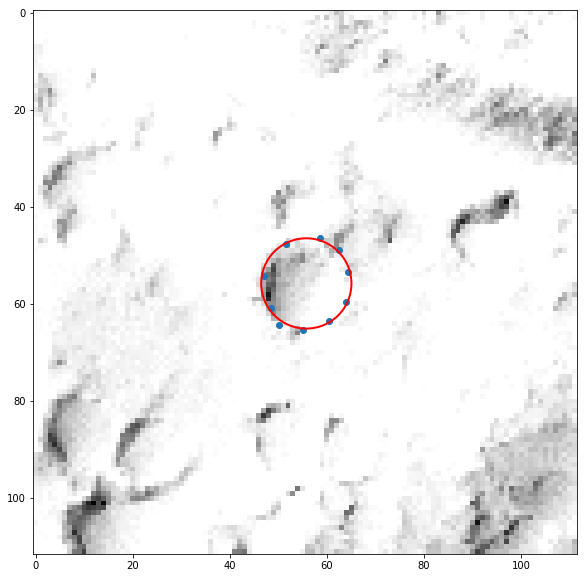

In [4]:
val_rims[78].show()

TypeError: get_pred() missing 1 required positional argument: 'model'

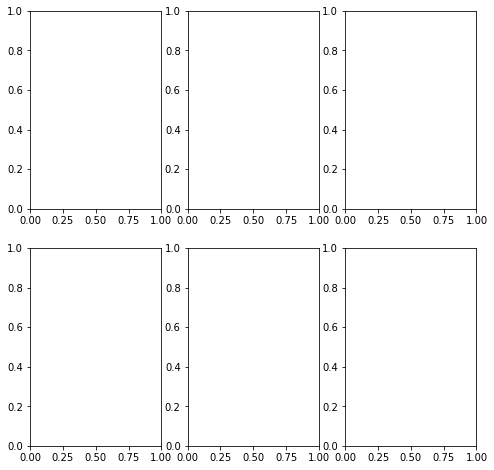

In [47]:
from sklearn.mixture import GaussianMixture

def get_pred(X, Y, model):
    X = np.expand_dims(make_channels(X), axis=0)/255
    Y = np.expand_dims(Y, axis=0)/255
    Y_pred = model.predict(X)
    return X[0, :, :, 0], Y[0], Y_pred[0]

def get_active_pixels(X, Y, model, rescale=1, disp=(0, 0)):
    img, Y, Y_pred = get_pred(X, Y, model)
    flat = Y_pred.flatten()
    values = flat[np.argwhere(flat > .1)][:, 0]
    gmm = GaussianMixture(n_components=2)
    gmm.fit(values.reshape(-1, 1))
    pred = gmm.predict(values.reshape(-1, 1))
    c0 = values[np.argwhere(pred==0)]
    c1 = values[np.argwhere(pred==1)]
    top_group = max(c0.mean(), c1.mean())
    if top_group == c0.mean():
        bum_group = c1
    else:
        bum_group = c0
    #threshold = max(gmm.means_)
    #threshold = bum_group.max()
    threshold=.1
    active_pixels = np.where(Y_pred > threshold, 1, 0)
    return active_pixels, values, threshold, img

def plot_distro(rim, model, rescale=1, disp=(0, 0)):
    #X, Y = prepare_image(rim, rescale=rescale, disp=disp)
    #img = X[0, :, :, 0]
    #Y_pred = model.predict(X)[0]
    fig, ax_ = plt.subplots(2, 3, figsize=(8, 8));
    ax = ax_[0]
    img, Y, Y_pred = get_pred(rim, model)
    active_pixels, values, threshold = get_active_pixels(rim, model, rescale=rescale, disp=disp)
    ax[1].imshow(img)
    ax[1].imshow(Y, alpha=.5)
    ax[1].set_title('Human Trace')
    ax[2].hist(values, bins=50);
    ax[2].axvline(x=threshold, linestyle='dotted', color='black', label='Gaussian Mixture Threshold')
    ax[2].legend();
    ax[2].set_title('Output Pixel Value Distribution');
    ax[0].imshow(img, cmap='Greys_r');
    ax[0].set_title('Input Image')
    ax = ax_[1]
    ax[0].imshow(img)
    ax[0].imshow(Y_pred, alpha=.5)
    ax[0].set_title('Output Heatmap')
    ax[1].remove()
    ax[2].imshow(img)
    ax[2].imshow(active_pixels, alpha=.5)
    ax[2].set_title('All Pixels > Threshold')
    plt.show()
    
#model = load_model('./models/thin_net2.h5')
#plot_distro(val_rims[761], model)

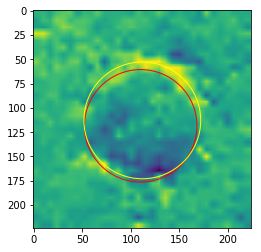

In [65]:
img, target, coords = val_rims[4].draw_rim(rot=69, crop_off=.35, incl_coords=True)

def px_to_circle(X, Y, model):
    px, _, _, img = get_active_pixels(X, Y, model)
    points = np.argwhere(px)
    x, y, r, s = hyper_fit(points)
    return x, y, r, s, img

def straight_fit(coords):
    x, y, r, s = hyper_fit(coords)
    return x, y, r, s

fig, ax = plt.subplots()
ax.imshow(img)
x, y, r, s, img = px_to_circle(img, target, model)
model_circle = plt.Circle((x, y), r, fill=False, color='red')
x, y, r, s = straight_fit(coords)
straight_circle = plt.Circle((x, y), r, fill=False, color='yellow')
ax.add_artist(model_circle)
ax.add_artist(straight_circle)
#plt.imshow(target, alpha=.5)

In [9]:
from rim_finder import make_deepnet

model = make_deepnet(w=8)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 224, 224, 3)  12          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 224, 224, 16) 448         batch_normalization_11[0][0]     
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 224, 224, 32) 4640        conv2d_51[0][0]                  
__________________________________________________________________________________________________
batch_norm

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import SGD
from focal_loss import focal_loss

#model = load_model('./models/sigmoid.h5')
callbacks = []
callbacks.append(ModelCheckpoint('./models/thin_net3.h5', save_best_only=True, monitor='val_loss', verbose=True))

model.compile(
    optimizer = SGD(lr=1e-5, decay=1e-6, momentum=.5),
    #optimizer=Adam(lr=1e-5, beta_1=0.5, decay=1e-5),
    #optimizer='adam',
    #optimizer=SGD(),
    #loss=focal_loss(alpha=.25, gamma=2),
    #metrics=['binary_crossentropy'],
    loss='binary_crossentropy'
)

val_steps = len(val_rims)//val_batch_size
steps = len(train_rims)//train_batch_size
history = model.fit_generator(
    train_gen,
    steps_per_epoch=steps,
    epochs=10,
    validation_data = val_gen,
    validation_steps = val_steps,
    verbose=True,
    callbacks=callbacks
)

Epoch 1/10
420/420 [==============================] - 404s 961ms/step - loss: 0.0254 - val_loss: 0.0186

Epoch 00001: val_loss improved from inf to 0.01863, saving model to ./models/thin_net3.h5
Epoch 2/10
420/420 [==============================] - 398s 948ms/step - loss: 0.0254 - val_loss: 0.0186

Epoch 00002: val_loss improved from 0.01863 to 0.01857, saving model to ./models/thin_net3.h5
Epoch 3/10
420/420 [==============================] - 398s 949ms/step - loss: 0.0255 - val_loss: 0.0185

Epoch 00003: val_loss improved from 0.01857 to 0.01847, saving model to ./models/thin_net3.h5
Epoch 4/10
420/420 [==============================] - 399s 949ms/step - loss: 0.0253 - val_loss: 0.0186

Epoch 00004: val_loss did not improve from 0.01847
Epoch 5/10
420/420 [==============================] - 399s 949ms/step - loss: 0.0253 - val_loss: 0.0186

Epoch 00005: val_loss did not improve from 0.01847
Epoch 6/10
154/420 [==========>...................] - ETA: 4:05 - loss: 0.0251

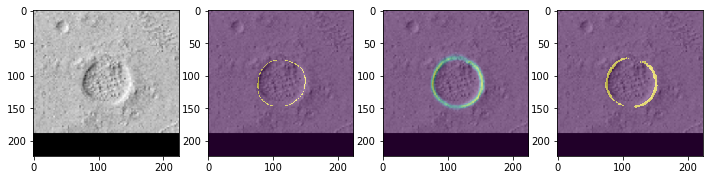

In [29]:
#X, Y = next(val_gen)
#Y_pred = model.predict(X)
see = 5
fig, ax = plt.subplots(1, 4, figsize=(12, 4))
img = X[see, :, :, 0]
ax[0].imshow(img, cmap='Greys_r')
ax[1].imshow(img, cmap='Greys_r')
ax[1].imshow(Y[see], alpha=.5)
ax[2].imshow(img, cmap='Greys_r')
ax[2].imshow(Y_pred[see], alpha=.5)
ax[3].imshow(img, cmap='Greys_r')
ax[3].imshow(np.where(Y_pred[see]>.30, 1, 0), alpha=.5)
plt.show()

In [ ]:
def plot_distro(X, Y, model rescale=1, disp=(0, 0)):
    img = X[0, :, :, 0]
    Y_pred = model.predict(X)[0]
    flat = Y_pred.flatten()
    values = flat[np.argwhere(flat > .1)][:, 0]
    fig, ax_ = plt.subplots(2, 2, figsize=(8, 8));
    ax = ax_[0]
    gmm = GaussianMixture(n_components=2)
    gmm.fit(values.reshape(-1, 1))
    pred = gmm.predict(values.reshape(-1, 1))
    c0 = values[np.argwhere(pred==0)]
    c1 = values[np.argwhere(pred==1)]
    top_group = max(c0.mean(), c1.mean())
    if top_group == c0.mean():
        bum_group = c1
    else:
        bum_group = c0
    threshold = max(gmm.means_)
    ax[1].hist(values, bins=50);
    ax[1].axvline(x=threshold, linestyle='dotted', color='black', label='Gaussian Mixture Threshold')
    ax[1].legend();
    ax[1].set_title('Output Pixel Value Distribution');
    ax[0].imshow(img, cmap='Greys_r');
    ax[0].set_title('Input Image')
    ax = ax_[1]
    ax[0].imshow(img)
    ax[0].imshow(Y_pred, alpha=.5)
    ax[0].set_title('Output Heatmap')
    ax[1].imshow(img)
    ax[1].imshow(np.where(Y_pred > threshold, 1, 0), alpha=.5)
    ax[1].set_title('All Pixels > Threshold')
    plt.show()

In [30]:
model.save('./models/thin_overfit.h5')